In [3]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.layers import BatchNormalization
from collections import defaultdict
from textblob import TextBlob
import inflect
import os
# Modelling
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

2023-09-06 06:53:30.721320: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Exploratory Data Analysis

In [3]:
# Read datasets
df = pd.read_csv('./text_emotion.csv')

In [4]:
#print first 5 rows
df.head()

tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...

In [5]:
#print the number of null values in each column
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

In [6]:
df_fet = df.drop(['tweet_id', 'author'], axis=1)
df_fet

sentiment                                            content
0           empty  @tiffanylue i know  i was listenin to bad habi...
1         sadness  Layin n bed with a headache  ughhhh...waitin o...
2         sadness                Funeral ceremony...gloomy friday...
3      enthusiasm               wants to hang out with friends SOON!
4         neutral  @dannycastillo We want to trade with someone w...
...           ...                                                ...
39995     neutral                                   @JohnLloydTaylor
39996        love                     Happy Mothers Day  All my love
39997        love  Happy Mother's Day to all the mommies out ther...
39998   happiness  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999        love  @mopedronin bullet train from tokyo    the gf ...

[40000 rows x 2 columns]

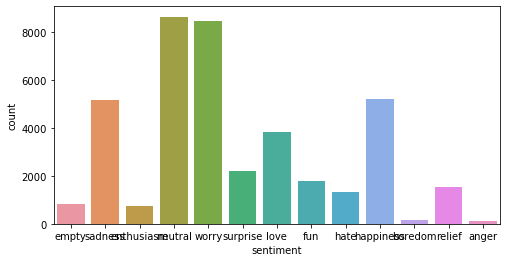

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_fet);

In [8]:
df_fet.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [9]:
def map_new_classes(sentiment):
    if sentiment in ['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger']:
        return sentiment
    elif sentiment == 'joyful':  # Map 'excited' to 'excitement'
        return 'joy'
    elif sentiment == 'fearful':  # Map 'disgusted' to 'disgust'
        return 'fear'
    

# Assuming your DataFrame is called 'df' and the column with classes is called 'sentiment'
df_fet['sentiment'] = df_fet['sentiment'].map(map_new_classes)
# Check the updated class distribution
print(df_fet['sentiment'].value_counts())

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


In [10]:
# Create a mapping of old classes to new classes
class_mapping = {
    'anger': 'other',
    'love': 'love',
    'sadness': 'sadness',
    'surprise': 'other',
    'joy': 'joy',
    'fear': 'fear',
    'neutral': 'neutral',
    'happiness': 'joy',
    'fun': 'joy',
    'relief': 'joy',
    'hate': 'other',
    'empty': 'sadness',
    'enthusiasm': 'joy',
    'boredom': 'sadness',
    'worry': 'fear',
    'other': 'other',
    
}

# Map the old classes to new classes in the 'Emotion' column of your DataFrame
df_fet['sentiment'] = df_fet['sentiment'].map(class_mapping)

plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_fet);

# Check the updated class distribution
print(df_fet['sentiment'].value_counts())


joy        9270
neutral    8638
fear       8459
sadness    6171
love       3842
other      3620
Name: sentiment, dtype: int64


In [11]:
#print the number of duplicated values 
df_fet.duplicated().sum()

95

In [12]:
#print the rows which are duplicated
df_fet[df_fet['content'].duplicated() == True]

sentiment                                        content
366        fear             I feel so deflated. No more doggy.
521        fear          Somebody please save the polar bears!
1026    neutral                                    I'm at work
3684    sadness      @dublins98dave me too! I am down 400 euro
4363       fear        is upset, I left my phone at home again
...         ...                                            ...
39859      love                              Happy Mothers Day
39898      love                             happy mothers day!
39913       joy                            happy mother's day!
39915      love                    happy mother's day everyone
39945      love  Happy Mother's Day to all the moms out there!

[173 rows x 2 columns]

In [13]:
#removing duplicated text
index = df_fet[df_fet['content'].duplicated() == True].index
df_fet.drop(index, axis = 0, inplace = True)
df_fet.reset_index(inplace=True, drop = True)

In [14]:
df_fet

sentiment                                            content
0       sadness  @tiffanylue i know  i was listenin to bad habi...
1       sadness  Layin n bed with a headache  ughhhh...waitin o...
2       sadness                Funeral ceremony...gloomy friday...
3           joy               wants to hang out with friends SOON!
4       neutral  @dannycastillo We want to trade with someone w...
...         ...                                                ...
39822   neutral                                   @JohnLloydTaylor
39823      love                     Happy Mothers Day  All my love
39824      love  Happy Mother's Day to all the mommies out ther...
39825       joy  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39826      love  @mopedronin bullet train from tokyo    the gf ...

[39827 rows x 2 columns]

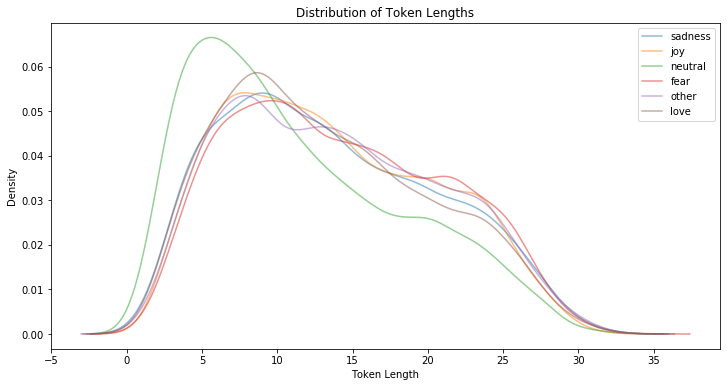

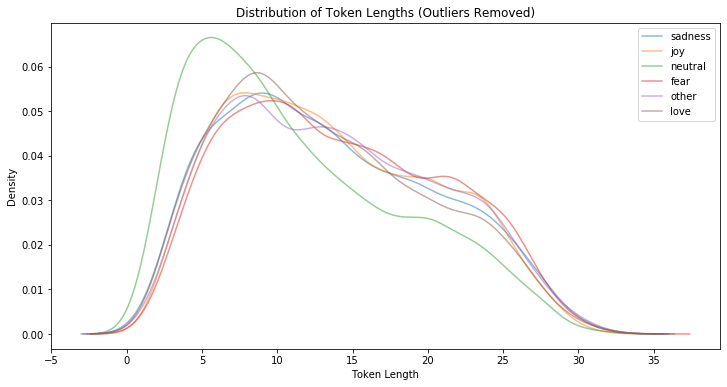

           token_length  char_length
sentiment                           
fear          14.145431    76.821145
joy           13.666847    76.855612
love          13.290621    74.839894
neutral       11.373343    64.620144
other         13.866593    76.891780
sadness       13.583591    73.699431
Average Token and Character Lengths by Sentiment (Outliers Removed):
           token_length  char_length
sentiment                           
fear          14.145431    76.821145
joy           13.666847    76.855612
love          13.290621    74.839894
neutral       11.373343    64.620144
other         13.866593    76.891780
sadness       13.583591    73.699431
Detected Outliers:
Empty DataFrame
Columns: [sentiment, content, token_length, char_length]
Index: []


In [15]:

# Assuming df_fet is your DataFrame with 'content' and 'sentiment' columns

# Calculate token lengths and add as a new column
df_fet['token_length'] = df_fet['content'].apply(lambda x: len(x.split()))

# Calculate character lengths and add as a new column
df_fet['char_length'] = df_fet['content'].apply(len)

# Group data by sentiment and calculate average token and character lengths
grouped = df_fet.groupby('sentiment')[['token_length', 'char_length']].mean()

# Calculate IQR for token and character lengths
Q1 = df_fet[['token_length', 'char_length']].quantile(0.25)
Q3 = df_fet[['token_length', 'char_length']].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for IQR to identify outliers
iqr_threshold = 1.5

# Detect outliers based on IQR
outliers = df_fet[
    ((df_fet[['token_length', 'char_length']] < (Q1 - iqr_threshold * IQR)) |
    (df_fet[['token_length', 'char_length']] > (Q3 + iqr_threshold * IQR))).any(axis=1)
]

# Plot the distribution of token lengths using KDE
plt.figure(figsize=(12, 6))
for sentiment in df_fet['sentiment'].unique():
    sns.kdeplot(df_fet[df_fet['sentiment'] == sentiment]['token_length'], label=sentiment, alpha=0.5)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.legend()
plt.show()

# ... Similar plots for character lengths

# Plot the distribution of token lengths after removing outliers using KDE
plt.figure(figsize=(12, 6))
for sentiment in df_fet['sentiment'].unique():
    sns.kdeplot(df_fet[~df_fet.index.isin(outliers.index) & (df_fet['sentiment'] == sentiment)]['token_length'], label=sentiment, alpha=0.5)
plt.title('Distribution of Token Lengths (Outliers Removed)')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.legend()
plt.show()

# ... Similar plots for character lengths

# Display the average token and character lengths by sentiment
print(grouped)

# Display the average token and character lengths by sentiment after removing outliers
grouped_no_outliers = df_fet[~df_fet.index.isin(outliers.index)].groupby('sentiment')[['token_length', 'char_length']].mean()
print("Average Token and Character Lengths by Sentiment (Outliers Removed):")
print(grouped_no_outliers)

# Display the detected outliers
print("Detected Outliers:")
print(outliers)


In [16]:

# Separate the input features (X) and the target variable (y)
x = df_fet['content']
y = df_fet['sentiment']

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_remaining, x_test, y_remaining, y_test = train_test_split(
    x, y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
x_train, x_val, y_train, y_val = train_test_split(
    x_remaining, y_remaining, test_size=ratio_val_adjusted)

# Compiling into one dataframe
train_df = pd.concat([y_train, x_train], axis=1)
test_df = pd.concat([y_test, x_test], axis=1)
val_df = pd.concat([y_val, x_val], axis=1)

train_df

sentiment                                            content
16097   sadness                Shit night. want john  where is he?
16872      fear       /me really sad that /me can't go to Java One
8496    neutral                                @iNetters thank you
24713      fear  is taking the dog to the vet then a play date ...
1557       fear  @ErikVeland Dude... That sucks! Why would they...
...         ...                                                ...
29991       joy                  Massive morning.. I'm stuffed now
3275    sadness  Woe, it's definitely NO fun to travel first cl...
35947      love  @heycassadee thanks for following, it means a ...
14899   neutral             @mell_e im going to my dance class now
25394       joy  Early monday cramming... yay. Only a few weeks...

[31861 rows x 2 columns]

In [36]:
type(train_df)

pandas.core.frame.DataFrame

Bar Chart of most frequent words for the sentiment: neutral
Number of Rows:  8598


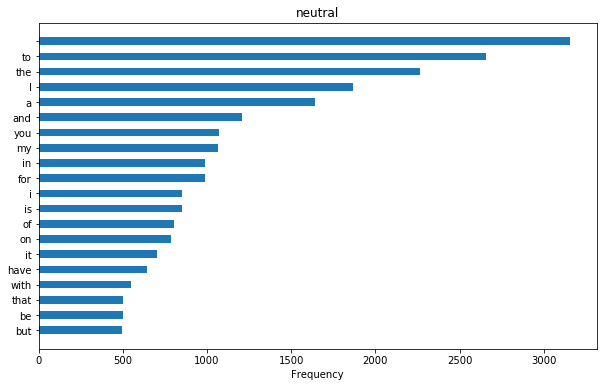

Bar Chart of most frequent words for the sentiment: joy
Number of Rows:  9239


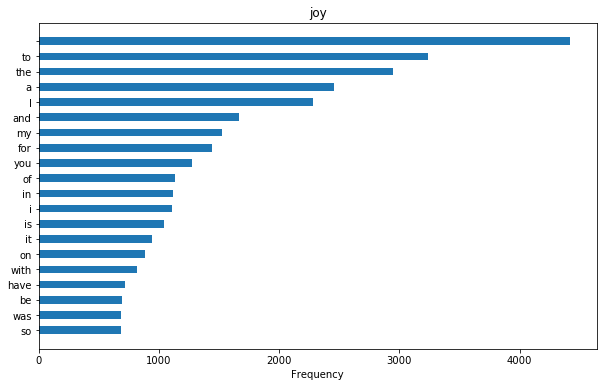

Bar Chart of most frequent words for the sentiment: fear
Number of Rows:  8437


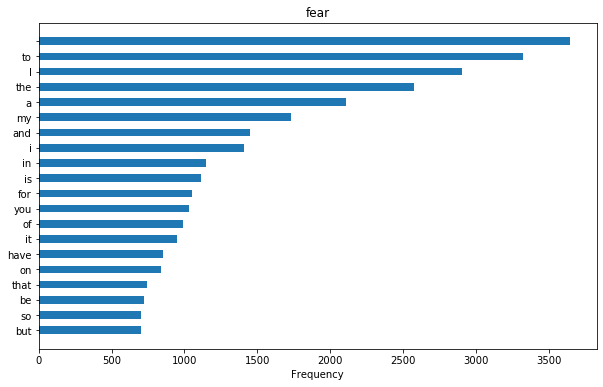

Bar Chart of most frequent words for the sentiment: sadness
Number of Rows:  6155


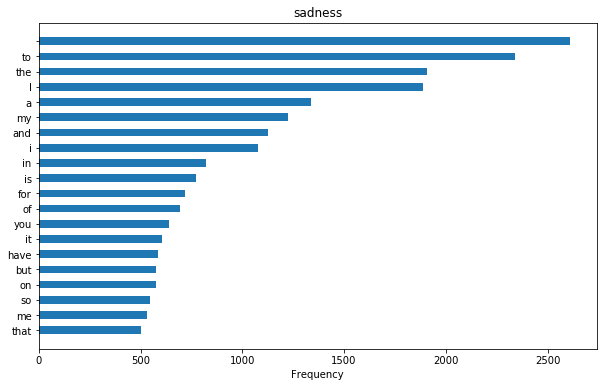

Bar Chart of most frequent words for the sentiment: love
Number of Rows:  3785


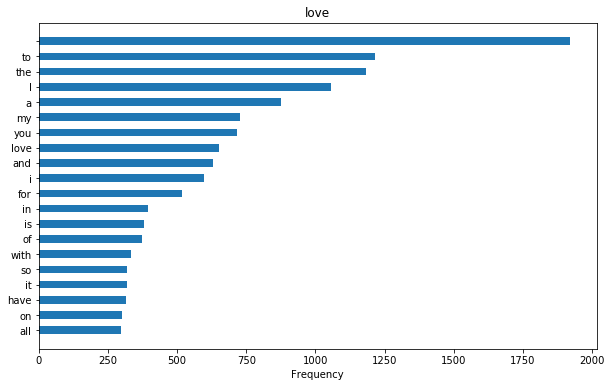

Bar Chart of most frequent words for the sentiment: other
Number of Rows:  3613


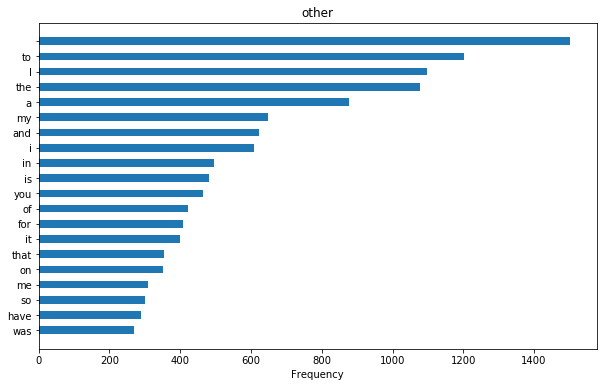

In [17]:

def plot_stopwords_bar_chart(df, sentiment):
    print("Bar Chart of most frequent words for the sentiment: {}".format(sentiment))
    
    temp_df = df[df['sentiment'] == sentiment]
    print("Number of Rows: ", len(temp_df))
    
    corpus = ''
    for text in temp_df.content:
        text = str(text)
        corpus += text
        
    total = 0
    count = defaultdict(lambda: 0)
    for word in corpus.split(" "):
        total += 1
        count[word] += 1
        
    top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
    top20words = [i[0] for i in top20pairs]
    top20freq = [i[1] for i in top20pairs]
    
    xs = np.arange(len(top20words))
    width = 0.5

    fig, ax = plt.subplots(figsize=(10, 6))                                                               
    ax.barh(xs, top20freq, height=width, align='center')

    ax.set_yticks(xs)
    ax.set_yticklabels(top20words)
    plt.gca().invert_yaxis()  # Invert y-axis to display words from top to bottom
    plt.xlabel('Frequency')
    plt.title(sentiment)
    
    plt.show()
# List of sentiments in your dataset
sentiments = ['neutral', 'joy', 'fear', 'sadness', 'love', 'other']

# Loop through each sentiment and plot the bar chart
for sentiment in sentiments:
    plot_stopwords_bar_chart(df_fet, sentiment)



# Data Pre-processing

In [18]:

train_df

sentiment                                            content
16097   sadness                Shit night. want john  where is he?
16872      fear       /me really sad that /me can't go to Java One
8496    neutral                                @iNetters thank you
24713      fear  is taking the dog to the vet then a play date ...
1557       fear  @ErikVeland Dude... That sucks! Why would they...
...         ...                                                ...
29991       joy                  Massive morning.. I'm stuffed now
3275    sadness  Woe, it's definitely NO fun to travel first cl...
35947      love  @heycassadee thanks for following, it means a ...
14899   neutral             @mell_e im going to my dance class now
25394       joy  Early monday cramming... yay. Only a few weeks...

[31861 rows x 2 columns]

In [20]:

# Function to correct spelling in a given text
def correct_spelling(text):
    blob = TextBlob(text)
    corrected_text = blob.correct()
    return str(corrected_text)

# Apply spelling correction to train_df
train_df['content'] = train_df['content'].apply(correct_spelling)

# Apply spelling correction to val_df
val_df['content'] = val_df['content'].apply(correct_spelling)

# Apply spelling correction to test_df
test_df['content'] = test_df['content'].apply(correct_spelling)


In [22]:
train_df.to_csv('./sp_train.csv', index=False)
val_df.to_csv('./sp_val.csv', index=False)
test_df.to_csv('./sp_test.csv', index=False)

In [33]:
train_df = pd.read_csv('./sp_train.csv')
val_df = pd.read_csv('./sp_val.csv')
test_df = pd.read_csv('./sp_test.csv')


(3983, 2)

In [4]:

def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

In [5]:
train_df['content'] = train_df['content'].apply(lambda text: denoise_text(text))
val_df['content'] = val_df['content'].apply(lambda text: denoise_text(text))
test_df['content'] = test_df['content'].apply(lambda text: denoise_text(text))
train_df

sentiment                                            content
0       sadness                 Hit night. want john  where is he?
1          fear      /me really sad that /me cannot go to Cava One
2       neutral                                 @letters thank you
3          fear  is taking the dog to the met then a play date ...
4          fear  @ErikVeland Rude... That sucks! Why would they...
...         ...                                                ...
31856       joy                 Passive morning.. I am stuffed now
31857   sadness  Toe, it is definitely of fun to travel first c...
31858      love  @heycassadee thanks for following, it means a ...
31859   neutral             @mellow in going to my dance class now
31860       joy  Early monday charming... may. Only a few weeks...

[31861 rows x 2 columns]

In [6]:
def remove_name_tags(text):
    # Use regex to match @username and @mention patterns
    return re.sub(r'@\w+', '', text)

In [7]:
train_df['content'] = train_df['content'].apply(lambda text: remove_name_tags(text))
val_df['content'] = val_df['content'].apply(lambda text: remove_name_tags(text))
test_df['content'] = test_df['content'].apply(lambda text: remove_name_tags(text))
train_df

sentiment                                            content
0       sadness                 Hit night. want john  where is he?
1          fear      /me really sad that /me cannot go to Cava One
2       neutral                                          thank you
3          fear  is taking the dog to the met then a play date ...
4          fear   Rude... That sucks! Why would they tow it fro...
...         ...                                                ...
31856       joy                 Passive morning.. I am stuffed now
31857   sadness  Toe, it is definitely of fun to travel first c...
31858      love   thanks for following, it means a lot to me  i...
31859   neutral                     in going to my dance class now
31860       joy  Early monday charming... may. Only a few weeks...

[31861 rows x 2 columns]

In [8]:
def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


In [9]:
train_df['content'] = train_df['content'].apply(lambda text: Removing_urls(text))
val_df['content'] = val_df['content'].apply(lambda text: Removing_urls(text))
test_df['content'] = test_df['content'].apply(lambda text: Removing_urls(text))
train_df

sentiment                                            content
0       sadness                 Hit night. want john  where is he?
1          fear      /me really sad that /me cannot go to Cava One
2       neutral                                          thank you
3          fear  is taking the dog to the met then a play date ...
4          fear   Rude... That sucks! Why would they tow it fro...
...         ...                                                ...
31856       joy                 Passive morning.. I am stuffed now
31857   sadness  Toe, it is definitely of fun to travel first c...
31858      love   thanks for following, it means a lot to me  i...
31859   neutral                     in going to my dance class now
31860       joy  Early monday charming... may. Only a few weeks...

[31861 rows x 2 columns]

In [10]:

punctuations =r'[.,#-*/]+'
# Define a regular expression to match one or more punctuations

# Remove punctuations
train_df['content'] = train_df['content'].apply(lambda text: re.sub(punctuations, '', text))
val_df['content'] = val_df['content'].apply(lambda text: re.sub(punctuations, '', text))
test_df['content'] = test_df['content'].apply(lambda text: re.sub(punctuations, '', text))

train_df

sentiment                                            content
0       sadness                  Hit night want john  where is he?
1          fear        me really sad that me cannot go to Cava One
2       neutral                                          thank you
3          fear  is taking the dog to the met then a play date ...
4          fear   Rude That sucks! Why would they tow it from y...
...         ...                                                ...
31856       joy                   Passive morning I am stuffed now
31857   sadness  Toe it is definitely of fun to travel first cl...
31858      love   thanks for following it means a lot to me  i ...
31859   neutral                     in going to my dance class now
31860       joy    Early monday charming may Only a few weeks left

[31861 rows x 2 columns]

In [11]:
def lower_case(text):
    return text.lower()

In [12]:
train_df['content'] = train_df['content'].apply(lambda text: lower_case(text))
val_df['content'] = val_df['content'].apply(lambda text: lower_case(text))
test_df['content'] = test_df['content'].apply(lambda text: lower_case(text))
train_df

sentiment                                            content
0       sadness                  hit night want john  where is he?
1          fear        me really sad that me cannot go to cava one
2       neutral                                          thank you
3          fear  is taking the dog to the met then a play date ...
4          fear   rude that sucks! why would they tow it from y...
...         ...                                                ...
31856       joy                   passive morning i am stuffed now
31857   sadness  toe it is definitely of fun to travel first cl...
31858      love   thanks for following it means a lot to me  i ...
31859   neutral                     in going to my dance class now
31860       joy    early monday charming may only a few weeks left

[31861 rows x 2 columns]

In [13]:
p = inflect.engine()

def replace_numbers_in_text(text):
    words = text.split()
    new_words = [p.number_to_words(word) if word.isdigit() else word for word in words]
    return " ".join(new_words)


In [14]:
train_df['content'] = train_df['content'].apply(lambda text: replace_numbers_in_text(text))
val_df['content'] = val_df['content'].apply(lambda text: replace_numbers_in_text(text))
test_df['content'] = test_df['content'].apply(lambda text: replace_numbers_in_text(text))
train_df

sentiment                                            content
0       sadness                   hit night want john where is he?
1          fear        me really sad that me cannot go to cava one
2       neutral                                          thank you
3          fear  is taking the dog to the met then a play date ...
4          fear  rude that sucks! why would they tow it from yo...
...         ...                                                ...
31856       joy                   passive morning i am stuffed now
31857   sadness  toe it is definitely of fun to travel first cl...
31858      love  thanks for following it means a lot to me i lo...
31859   neutral                     in going to my dance class now
31860       joy    early monday charming may only a few weeks left

[31861 rows x 2 columns]

In [15]:

sentiment_related_stopwords = [
    "not", "no", "never", "none", "nobody", "nothing", "nowhere",
    "love", "hate", "like", "dislike", "enjoy", "unlike",
    "happy", "sad", "angry", "glad", "mad",
    "good", "bad", "better", "worse",
    "beautiful", "ugly", "pretty",
    "awesome", "terrible", "amazing",
    "very", "extremely", "so", "too",
    "wow", "yay", "ugh",
    "why", "how", "what", "when", "where",
    "well", "okay", "oops",
    "can't", "won't", "ain't",
    ":-)", ":)", ":-(", ":(",
    "imho", "lol", "omg", "btw", "brb",
    "great", "fantastic", "excellent",
    "best", "worst", "perfect",
    "yes", "nope", "maybe",
    "please", "thank you",
    "hmm", "uh", "uhh", "uhm",
    "haha", "hehe", "hi", "hey", "hello",
    "cool", "awesome", "amazing",
    "even", "ever", "every", "everyone",
    "but", "if", "however", "although",
    "while", "unless", "whether", "except",
    "should", "would", "could", "might",
    "shall", "will", "can",
    "now", "then", "later",
    "since", "before", "after", "when", "while",
    "about", "above", "below", "over", "under",
    "also", "besides", "instead", "meanwhile",
    "all", "any", "each", "few", "most", "some", "none",
    "such", "several", "many", "much", "every", "whole",
    "i", "me", "my", "mine", "myself",
    "you", "your", "yours", "yourself",
    "he", "him", "his", "himself",
    "she", "her", "hers", "herself",
    "it", "its", "itself",
    "we", "us", "our", "ours", "ourselves",
    "they", "them", "their", "theirs", "themselves"
]

nltk_stopwords = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    removed_words = [word for word in words if word.lower() in nltk_stopwords and word.lower() not in sentiment_related_stopwords]
    
    # Create a list of stopwords removed
    stopwords_removed = [word for word in words if word.lower() in nltk_stopwords and word.lower() not in sentiment_related_stopwords]
    
    cleaned_words = [word for word in words if word.lower() not in nltk_stopwords or word.lower() in sentiment_related_stopwords]
    
    # Calculate and display the total count of stopwords removed
    total_stopwords_removed = len(removed_words)
    print(f"Total stopwords removed: {total_stopwords_removed}")
    
    # Display the list of stopwords removed
    print("Stopwords removed:")
    print(stopwords_removed)
    
    return ' '.join(cleaned_words)


In [16]:
train_df['content'] = train_df['content'].apply(lambda text: remove_stopwords(text))
val_df['content'] = val_df['content'].apply(lambda text: remove_stopwords(text))
test_df['content'] = test_df['content'].apply(lambda text: remove_stopwords(text))
train_df

Total stopwords removed: 1
Stopwords removed:
['is']
Total stopwords removed: 2
Stopwords removed:
['that', 'to']
Total stopwords removed: 0
Stopwords removed:
[]
Total stopwords removed: 6
Stopwords removed:
['is', 'the', 'to', 'the', 'a', 'with']
Total stopwords removed: 3
Stopwords removed:
['that', 'from', 'own']
Total stopwords removed: 6
Stopwords removed:
['to', 'out', 'be', 'in', 'of', 'that']
Total stopwords removed: 0
Stopwords removed:
[]
Total stopwords removed: 4
Stopwords removed:
['had', 'didn', 'have', 'a']
Total stopwords removed: 7
Stopwords removed:
['to', 'have', 'to', 'this', 'because', 'of', 'other']
Total stopwords removed: 4
Stopwords removed:
['a', 'on', 'and', 'at']
Total stopwords removed: 2
Stopwords removed:
['up', 'for']
Total stopwords removed: 1
Stopwords removed:
['is']
Total stopwords removed: 10
Stopwords removed:
['of', 'to', 'be', 'the', 'have', 'been', 'and', 'up', 'for', 'and']
Total stopwords removed: 4
Stopwords removed:
['to', 'am', 'and', 'are

sentiment                                            content
0       sadness                      hit night want john where he?
1          fear                me really sad me cannot go cava one
2       neutral                                          thank you
3          fear            taking dog met then play date annabelle
4          fear      rude sucks! why would they tow it your space?
...         ...                                                ...
31856       joy                      passive morning i stuffed now
31857   sadness  toe it definitely fun travel first class bike ...
31858      love  thanks following it means lot me i love hey mo...
31859   neutral                           going my dance class now
31860       joy           early monday charming may few weeks left

[31861 rows x 2 columns]

In [17]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

In [18]:
train_df['content'] = train_df['content'].apply(lambda text: lemmatization(text))
val_df['content'] = val_df['content'].apply(lambda text: lemmatization(text))
test_df['content'] = test_df['content'].apply(lambda text: lemmatization(text))
train_df

sentiment                                            content
0       sadness                      hit night want john where he?
1          fear                me really sad me cannot go cava one
2       neutral                                          thank you
3          fear            taking dog met then play date annabelle
4          fear      rude sucks! why would they tow it your space?
...         ...                                                ...
31856       joy                      passive morning i stuffed now
31857   sadness  toe it definitely fun travel first class bike ...
31858      love  thanks following it mean lot me i love hey mon...
31859   neutral                           going my dance class now
31860       joy            early monday charming may few week left

[31861 rows x 2 columns]

In [19]:
train_df.to_csv('./prepd_train.csv', index=False)
val_df.to_csv('./prepd_val.csv', index=False)
test_df.to_csv('./prepd_test.csv', index=False)

In [20]:
train_df_ANN = pd.read_csv('./prepd_train.csv')
val_df_ANN = pd.read_csv('./prepd_val.csv')
test_df_ANN = pd.read_csv('./prepd_test.csv')
train_df_ANN

sentiment                                            content
0       sadness                      hit night want john where he?
1          fear                me really sad me cannot go cava one
2       neutral                                          thank you
3          fear            taking dog met then play date annabelle
4          fear      rude sucks! why would they tow it your space?
...         ...                                                ...
31856       joy                      passive morning i stuffed now
31857   sadness  toe it definitely fun travel first class bike ...
31858      love  thanks following it mean lot me i love hey mon...
31859   neutral                           going my dance class now
31860       joy            early monday charming may few week left

[31861 rows x 2 columns]

In [21]:
# Check for NaN values in train_df_ANN['content']
print("NaN values in train_df_ANN['content']:")
print(train_df_ANN[train_df_ANN['content'].isna()])

# Remove rows with NaN values from train_df_ANN
train_df_ANN = train_df_ANN.dropna()

# Verify that NaN values are removed
print("\nNaN values removed:")
print("Train shape:", train_df_ANN.shape)

NaN values in train_df_ANN['content']:
      sentiment content
608     neutral     NaN
1533    neutral     NaN
1957    neutral     NaN
2807       fear     NaN
2913        joy     NaN
...         ...     ...
30242   neutral     NaN
30645      fear     NaN
31056   neutral     NaN
31455   neutral     NaN
31842   neutral     NaN

[82 rows x 2 columns]

NaN values removed:
Train shape: (31779, 2)


In [22]:
# Check for NaN values in val_df_ANN['content']
print("NaN values in val_df_ANN['content']:")
print(val_df_ANN[val_df_ANN['content'].isna()])

# Remove rows with NaN values from val_df_ANN
val_df_ANN = val_df_ANN.dropna()

# Verify that NaN values are removed
print("\nNaN values removed from val_df_ANN:")
print("Validation shape:", val_df_ANN.shape)



NaN values in val_df_ANN['content']:
     sentiment content
95     neutral     NaN
125    neutral     NaN
201    neutral     NaN
733    neutral     NaN
784    neutral     NaN
1878   neutral     NaN
1892   neutral     NaN
2367   neutral     NaN
3013      fear     NaN
3123   neutral     NaN

NaN values removed from val_df_ANN:
Validation shape: (3973, 2)


In [23]:
# Check for NaN values in test_df_ANN['content']
print("\nNaN values in test_df_ANN['content']:")
print(test_df_ANN[test_df_ANN['content'].isna()])

# Remove rows with NaN values from test_df_ANN
test_df_ANN = test_df_ANN.dropna()

# Verify that NaN values are removed
print("\nNaN values removed from test_df_ANN:")
print("Test shape:", test_df_ANN.shape)



NaN values in test_df_ANN['content']:
     sentiment content
610    neutral     NaN
822    neutral     NaN
1109   neutral     NaN
2768   neutral     NaN
3460   neutral     NaN

NaN values removed from test_df_ANN:
Test shape: (3978, 2)


In [24]:
train_df_ANN.to_csv('./fin_train.csv', index=False)
val_df_ANN.to_csv('./fin_val.csv', index=False)
test_df_ANN.to_csv('./fin_test.csv', index=False)

In [26]:
train_df_ANN = pd.read_csv('./fin_train.csv')
val_df_ANN = pd.read_csv('./fin_val.csv')
test_df_ANN = pd.read_csv('./fin_test.csv')
train_df_ANN

sentiment                                            content
0       sadness                      hit night want john where he?
1          fear                me really sad me cannot go cava one
2       neutral                                          thank you
3          fear            taking dog met then play date annabelle
4          fear      rude sucks! why would they tow it your space?
...         ...                                                ...
31774       joy                      passive morning i stuffed now
31775   sadness  toe it definitely fun travel first class bike ...
31776      love  thanks following it mean lot me i love hey mon...
31777   neutral                           going my dance class now
31778       joy            early monday charming may few week left

[31779 rows x 2 columns]

In [27]:
type(test_df_ANN)

pandas.core.frame.DataFrame

In [28]:
#Preprocess text
x_train = train_df_ANN['content'].values
Y_train = train_df_ANN['sentiment'].values

x_test = test_df_ANN['content'].values
Y_test = test_df_ANN['sentiment'].values

x_val = val_df_ANN['content'].values
Y_val = val_df_ANN['sentiment'].values

### TF-IDF
The word counts suffer some issues: most frequent words are usually not important (like stop words), while they take high focus/count.

TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:

TF: #mentions within a document

IDF: #mentions across all docs 

So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words appearing mostly in THIS doc (TF++, TFIDF--).

If a word appearing only in the current doc/sentence, it has TFIDF=1. If a word appears in all docs/sents but not the current one, it has TFIDF=0. If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

In [34]:
def train_model_tfidf(model, data, targets):
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [35]:
#Train the model with the training data
DT = train_model_tfidf(DecisionTreeClassifier(random_state = 0), x_train, Y_train)

#test the model with the test data
y_pred=DT.predict(x_test)



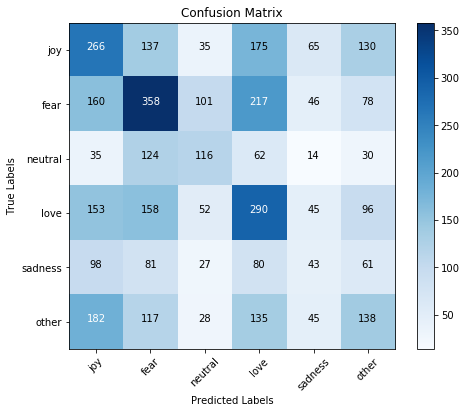

Classification Report:
               precision    recall  f1-score   support

        fear       0.30      0.33      0.31       808
         joy       0.37      0.37      0.37       960
        love       0.32      0.30      0.31       381
     neutral       0.30      0.37      0.33       794
       other       0.17      0.11      0.13       390
     sadness       0.26      0.21      0.23       645

    accuracy                           0.30      3978
   macro avg       0.29      0.28      0.28      3978
weighted avg       0.30      0.30      0.30      3978



In [36]:

# Calculate confusion matrix
confusion = confusion_matrix(Y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['joy', 'fear', 'neutral', 'love', 'sadness', 'other'] 
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display confusion matrix values on the plot
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i][j]), horizontalalignment='center', color='white' if confusion[i][j] > confusion.max() / 2 else 'black')

plt.show()

# Classification Report
print("Classification Report:\n", classification_report(Y_test, y_pred))


# Word embedding pipeline to fit the dataframe

In [4]:
train_df = pd.read_csv('./fin_train.csv')
val_df = pd.read_csv('./fin_val.csv')
test_df = pd.read_csv('./fin_train.csv')


In [5]:
## Text Preprocessing
#Splitting the text from the labels
X_trn = train_df['content']
y_trn = train_df['sentiment']

X_tst = test_df['content']
Y_tst = test_df['sentiment']

X_val = val_df['content']
y_val = val_df['sentiment']

y_trn.value_counts()

joy        7371
neutral    6852
fear       6804
sadness    4841
love       3042
other      2869
Name: sentiment, dtype: int64

In [6]:
# Encode labels
le = LabelEncoder()
y_trn = le.fit_transform(y_trn)
y_tst = le.transform(Y_tst)
y_val = le.transform(y_val)
#print the labels after encoding 
original_labels = le.inverse_transform(y_trn)
print(set(y_trn))
print(set(original_labels))

{0, 1, 2, 3, 4, 5}
{'love', 'neutral', 'joy', 'other', 'sadness', 'fear'}


In [7]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_trn)
y_test = to_categorical(y_tst)
y_val = to_categorical(y_val)
print(y_train)

[[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]



## Tokenizing

In [8]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_trn, X_tst], axis=0))

In [9]:
sequences_train = tokenizer.texts_to_sequences(X_trn)
sequences_test = tokenizer.texts_to_sequences(X_tst)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [10]:
#print the sentence after converting them to indexes
sequences_train

[[373, 43, 37, 982, 167, 28],
 [7, 35, 86, 7, 51, 18, 1929, 16],
 [124, 3],
 [332, 371, 355, 81, 258, 562, 8427],
 [1157, 959, 74, 45, 44, 4273, 4, 23, 608],
 [8428, 38, 23, 1630, 1011, 19, 223, 47, 48, 33, 10, 395],
 [2, 126, 15, 132, 6153],
 [2, 617, 2, 603],
 [8429, 1319, 56, 12, 3338],
 [3, 34, 264, 4274, 1766, 316, 268],
 [215, 1137, 100, 15, 22],
 [1138],
 [4, 54, 388, 2, 11, 3339, 2, 983, 90, 121, 2162, 333, 4996, 1930, 9, 270],
 [8430, 3, 32, 57, 2, 17, 381, 396, 2, 121, 8431, 12, 3],
 [3707, 59, 123, 78, 2, 17, 104, 100, 3708],
 [6154, 3, 188, 57, 2, 15, 2, 146, 2163],
 [33, 1084, 207, 96, 422],
 [173, 52, 6155],
 [6156, 15, 3709, 401, 6156, 437],
 [1840, 8432, 8433, 3340, 2433, 24, 4275, 467, 4276],
 [2, 15, 454, 5, 505, 901, 9, 28, 30, 412, 592, 6157, 2, 136, 18, 592],
 [2, 21, 78, 8, 3, 126, 1320, 7, 34, 4997, 86],
 [28, 902, 74, 6, 3, 18, 1931, 5, 6, 17, 5, 91],
 [57, 55],
 [90, 270, 38, 784, 73],
 [2,
  321,
  1841,
  117,
  113,
  6158,
  659,
  3710,
  8434,
  736,
  69

## Padding

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len. 


In [11]:
maxlen = max([len(t) for t in train_df['content']])
maxlen

211

In [12]:
X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_vald = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 20268


In [13]:
#before
sequences_train[0]

[373, 43, 37, 982, 167, 28]

In [14]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Word Embedding


**This code defines the following variables:**

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.


In [15]:
# download embeddings

if not os.path.isfile('./glove.twitter.27B.zip'):
    !wget 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'
    !unzip './glove.twitter.27B.zip'

In [16]:
# Read GloVE embeddings

path_to_glove_file = './glove.twitter.27B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}


I will intialize an embedding matrix with all zero values and then looping through the vocabulary (as defined by the tokenizer object) to assign word vectors to the corresponding rows of the embedding matrix. The word_index attribute of the tokenizer object is a dictionary that maps words to their indices in the vocabulary.

The embedding matrix will have a size of num_tokens rows and embedding_dim columns, where num_tokens is the size of the vocabulary and embedding_dim is the dimensionality of the word vectors.

For each word in the vocabulary, the code looks up the corresponding word vector in the embeddings_index dictionary and assigns it to the corresponding row of the embedding matrix. If the word is not found in the embeddings_index dictionary (i.e., if embedding_vector is None), the code increments the misses counter and the row of the embedding matrix remains all-zeros. If the word is found in the embeddings_index dictionary, the code increments the hits counter and assigns the word vector to the corresponding row of the embedding matrix. Finally, the code prints out the number of words that were converted (hits) and the number that were not found in the embeddings_index dictionary (misses).


In [17]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 1193514 word vectors.
Converted 13700 words (6567 misses)


# Model Training

#### training GRU 

In [51]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Embedding Layer: The model begins with an embedding layer. This layer converts integer-encoded input sequences into dense vectors of fixed size, allowing the model to learn relationships between different words based on their context. The weights parameter initializes the embedding layer with pre-trained word vectors, making the model aware of semantic relationships between words. The embedding layer is not trainable in your case (trainable=False), so the pre-trained embeddings will not be updated during training.

Bidirectional GRU Layers: The architecture employs three Bidirectional GRU layers stacked on top of each other. Each Bidirectional GRU processes the input sequence in both forward and backward directions, capturing contextual information from both past and future tokens. This bidirectional nature allows the model to better understand the context of each word within the entire sequence.

The first Bidirectional GRU layer has 256 units with dropout and recurrent dropout to prevent overfitting. It returns sequences because of return_sequences=True, which is necessary for the subsequent layers to receive sequence data.

The second Bidirectional GRU layer also has 128 units, dropout, and recurrent dropout, and it also returns sequences.

The third Bidirectional GRU layer has 64 units, dropout, and recurrent dropout. It doesn't return sequences, as it's intended to provide a final representation of the entire sequence.

Dense Layer: The final layer of the model is a Dense layer with 6 units (assuming it's a multi-class classification problem) and a softmax activation function. This layer converts the learned features from the previous layers into class probabilities.

Now, comparing this architecture with a single layer of GRU:

Depth of Representation: The main advantage of the provided architecture is its depth. The stacking of multiple Bidirectional GRU layers allows the model to learn hierarchical features and abstract representations at different levels of granularity. It captures increasingly complex patterns in the input sequence.

Contextual Understanding: The use of multiple Bidirectional GRU layers helps the model understand the context of each word within a broader context of the entire sequence. This can be crucial for tasks like sentiment analysis, where the sentiment of a sentence can depend on the context of the words around it.

Feature Learning: Each Bidirectional GRU layer learns a different level of representation. Shallower layers may capture basic syntactic structures, while deeper layers capture more abstract semantics. This hierarchy of feature learning can improve the model's ability to distinguish between subtle linguistic nuances.

Overall, the provided architecture with stacked Bidirectional GRU layers is likely to perform better than a single-layer GRU architecture because it can learn more intricate and contextual representations from the input data. However, it's important to note that the effectiveness of the architecture can also depend on the specific characteristics of your dataset and task.

In [52]:


adam = Adam(learning_rate=0.0005)

model_GRU_2 = Sequential()

model_GRU_2.add(Embedding(vocabSize, 200, input_length=maxlen, weights=[embedding_matrix], trainable=False))

model_GRU_2.add(Bidirectional(GRU(256, return_sequences=True)))
model_GRU_2.add(Bidirectional(GRU(128, return_sequences=True)))
model_GRU_2.add(Bidirectional(GRU(64)))
model_GRU_2.add(Dense(6, activation='softmax'))

model_GRU_2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 

model_GRU_2.summary()

2023-09-06 02:00:05.761359: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-09-06 02:00:05.877739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-06 02:00:05.878200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-09-06 02:00:05.878224: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-09-06 02:00:05.879860: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-09-06 02:00:05.879894: I tensorflow/stream_executor/pl

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 211, 200)          4053600   
_________________________________________________________________
bidirectional (Bidirectional (None, 211, 512)          703488    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 211, 256)          493056    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 5,374,566
Trainable params: 1,320,966
Non-trainable params: 4,053,600
_________________________________________________________________


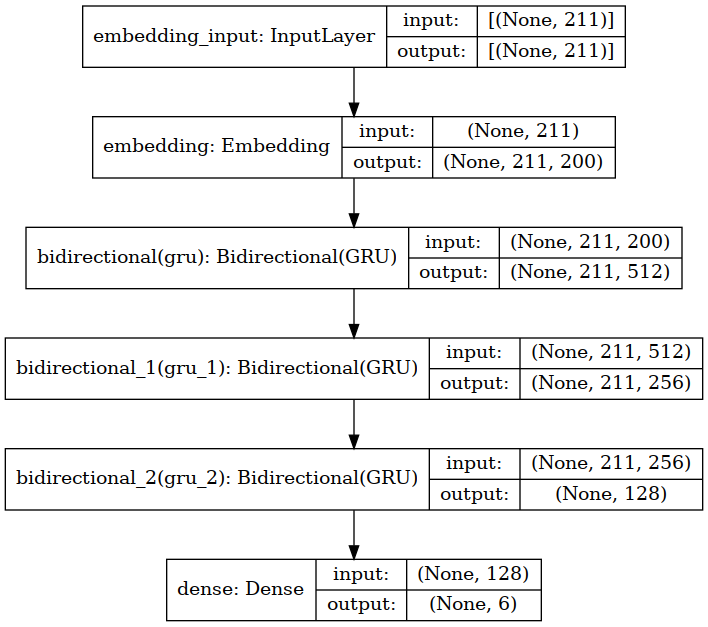

In [53]:

# Assuming you have a Keras model named 'model_GRU_2'
tf.keras.utils.plot_model(model_GRU_2, to_file='./model.png', show_shapes=True,show_layer_names=True, expand_nested=True)

# Display the saved image in your Jupyter Notebook or Python environment
Image('model.png')

In [56]:
history = model_GRU_2.fit(
        X_train, y_train,
        batch_size=64,
        epochs=21,
        validation_data=(X_vald, y_val),
        verbose=1  # Set verbose to 0 to avoid printing training logs
    )

Epoch 1/21
497/497 [==============================] - 24s 49ms/step - loss: 1.4182 - accuracy: 0.4365 - val_loss: 1.5087 - val_accuracy: 0.3992
Epoch 2/21
497/497 [==============================] - 24s 48ms/step - loss: 1.3925 - accuracy: 0.4485 - val_loss: 1.5146 - val_accuracy: 0.3952
Epoch 3/21
497/497 [==============================] - 23s 47ms/step - loss: 1.3536 - accuracy: 0.4684 - val_loss: 1.5296 - val_accuracy: 0.3929
Epoch 4/21
497/497 [==============================] - 24s 48ms/step - loss: 1.2918 - accuracy: 0.4966 - val_loss: 1.5762 - val_accuracy: 0.3788
Epoch 5/21
497/497 [==============================] - 24s 49ms/step - loss: 1.1981 - accuracy: 0.5388 - val_loss: 1.6319 - val_accuracy: 0.3723
Epoch 6/21
497/497 [==============================] - 24s 47ms/step - loss: 1.0599 - accuracy: 0.6012 - val_loss: 1.7379 - val_accuracy: 0.3607
Epoch 7/21
497/497 [==============================] - 24s 49ms/step - loss: 0.8762 - accuracy: 0.6793 - val_loss: 1.9441 - val_accuracy:

KeyboardInterrupt: 

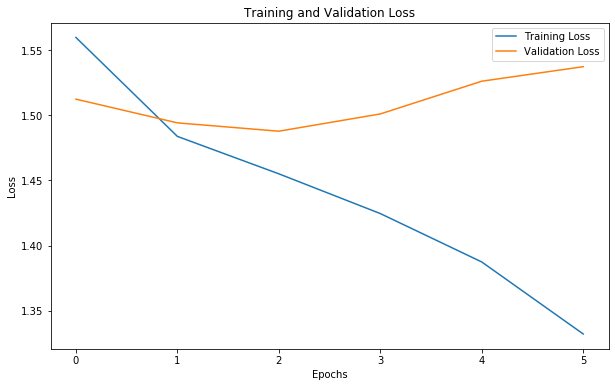

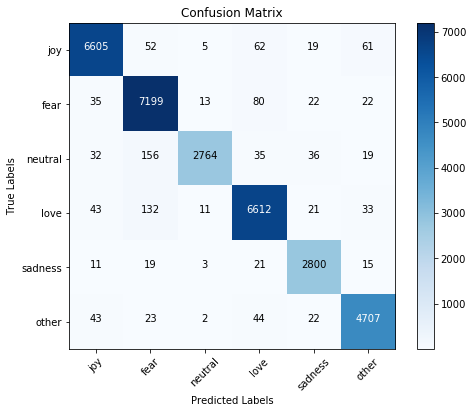

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      6804
           1       0.95      0.98      0.96      7371
           2       0.99      0.91      0.95      3042
           3       0.96      0.96      0.96      6852
           4       0.96      0.98      0.97      2869
           5       0.97      0.97      0.97      4841

    accuracy                           0.97     31779
   macro avg       0.97      0.96      0.96     31779
weighted avg       0.97      0.97      0.97     31779



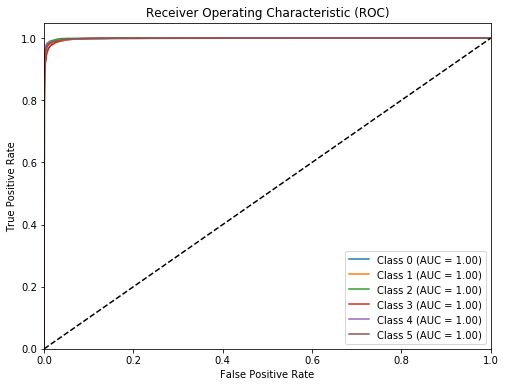

In [57]:
# Assuming you have already trained your 'model_GRU_2' and have test data 'X_test' and 'y_test'
y_pred = model_GRU_2.predict(X_test)

# Visualize Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Calculate confusion matrix
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['joy', 'fear', 'neutral', 'love', 'sadness', 'other']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display confusion matrix values on the plot
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i][j]), horizontalalignment='center', color='white' if confusion[i][j] > confusion.max() / 2 else 'black')

plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [58]:
model_GRU_2.save('./GRU_2_sentiment_analysis.h5')

In [23]:
# Load the pre-trained GRU model (replace './GRU_sentiment_analysis.h5' with your model path)

loaded_model = load_model('./GRU_sentiment_analysis.h5')

# Define your input text
input_text = "i am sad i am not on schedule for thesis"

# Tokenize words (use the same tokenizer you used for training)
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_trn, X_tst], axis=0))

# Convert input text to sequences
input_sequence = tokenizer.texts_to_sequences([input_text])

# Pad or truncate the sequence to match the max sequence length
maxlen = 211  # Use the same maxlen as used during training
input_sequence = pad_sequences(input_sequence, maxlen=maxlen, truncating='pre')


# Make predictions using the loaded model
predictions = loaded_model.predict(input_sequence)

# Assuming you have 6 classes (adjust as needed)
predicted_class = np.argmax(predictions, axis=-1)

# Print the predicted class
print(f"Predicted Class: {predicted_class}")
# it predicts the class as other whereas the sentiment is of saddness

Predicted Class: [5]


## **Training the DistilBERT model on the Training set**

In [2]:
train_df = pd.read_csv('./fin_train.csv')
val_df = pd.read_csv('./fin_val.csv')
test_df = pd.read_csv('./fin_test.csv')


In [3]:
## Text Preprocessing
#Splitting the text from the labels
X_trn = train_df['content']
y_trn = train_df['sentiment']

X_tst = test_df['content']
Y_tst = test_df['sentiment']

X_val = val_df['content']
y_val = val_df['sentiment']

y_trn.value_counts()

joy        7371
neutral    6852
fear       6804
sadness    4841
love       3042
other      2869
Name: sentiment, dtype: int64

In [4]:
# Encode labels
le = LabelEncoder()
y_trn = le.fit_transform(y_trn)
y_tst = le.transform(Y_tst)
y_val = le.transform(y_val)
#print the labels after encoding 
original_labels = le.inverse_transform(y_trn)
print(set(y_trn))
print(set(original_labels))

{0, 1, 2, 3, 4, 5}
{'love', 'sadness', 'other', 'fear', 'joy', 'neutral'}


In [5]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_trn)
y_test = to_categorical(y_tst)
y_val = to_categorical(y_val)
print(y_train)

[[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


Training data shapes:
Input IDs: (31779, 58)
Attention Masks: (31779, 58)
Val data shapes:
Input IDs: (3973, 58)
Attention Masks: (3973, 58)
Test data shapes:
Input IDs: (3978, 58)
Attention Masks: (3978, 58)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

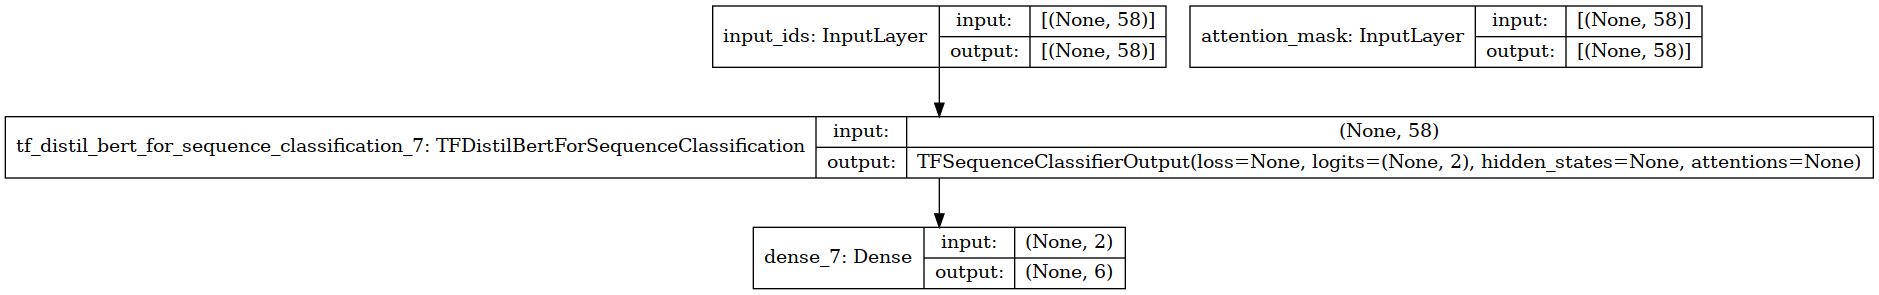

In [21]:


# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize and prepare inputs
X_trn_tokens = tokenizer(X_trn.tolist(), padding=True, truncation=True, return_tensors='np')
X_tst_tokens = tokenizer(X_tst.tolist(), padding=True, truncation=True, return_tensors='np')
X_val_tokens = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='np')

# Extract input IDs, attention masks, and segment IDs
X_trn_input_ids = X_trn_tokens['input_ids']
X_trn_attention_mask = X_trn_tokens['attention_mask']

X_tst_input_ids = X_tst_tokens['input_ids']
X_tst_attention_mask = X_tst_tokens['attention_mask']

X_val_input_ids = X_val_tokens['input_ids']
X_val_attention_mask = X_val_tokens['attention_mask']

# Find the maximum sequence length among all datasets

# Find the minimum sequence length among all datasets
min_seq_length = min(
    len(X_trn_input_ids[0]),
    len(X_val_input_ids[0]),
    len(X_tst_input_ids[0])
)

# Truncate sequences to match the minimum sequence length
X_trn_input_ids = pad_sequences(X_trn_input_ids, maxlen=min_seq_length, padding='post', truncating='post')
X_trn_attention_mask = pad_sequences(X_trn_attention_mask, maxlen=min_seq_length, padding='post', truncating='post')
X_val_input_ids = pad_sequences(X_val_input_ids, maxlen=min_seq_length, padding='post', truncating='post')
X_val_attention_mask = pad_sequences(X_val_attention_mask, maxlen=min_seq_length, padding='post', truncating='post')
X_tst_input_ids = pad_sequences(X_tst_input_ids, maxlen=min_seq_length, padding='post', truncating='post')
X_tst_attention_mask = pad_sequences(X_tst_attention_mask, maxlen=min_seq_length, padding='post', truncating='post')
# Now you have your inputs prepared with input IDs, attention masks, and segment IDs
print("Training data shapes:")
print("Input IDs:", X_trn_input_ids.shape)
print("Attention Masks:", X_trn_attention_mask.shape)
print("Val data shapes:")
print("Input IDs:", X_val_input_ids.shape)
print("Attention Masks:", X_val_attention_mask.shape)
print("Test data shapes:")
print("Input IDs:", X_tst_input_ids.shape)
print("Attention Masks:", X_tst_attention_mask.shape)


# Define the DistilBERT model
distil_bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Define inputs
input_ids = Input(shape=(min_seq_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(min_seq_length,), dtype='int32', name='attention_mask')

# Connect inputs to the DistilBERT model
sequence_output = distil_bert(input_ids, attention_mask=attention_mask)['logits']
#batch = BatchNormalization()(sequence_output)
output_layer = Dense(6, activation='softmax', kernel_regularizer=l2(0.01))(sequence_output) #(batch)(sequence_output) # Assuming you have 6 classes
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=2e-5, epsilon=1e-8)
loss_fn = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[CategoricalAccuracy()])


# Plot the model architecture
plot_model(
    model,
    to_file='distilbert_model.png',  # Output file name
    show_shapes=True,  # Show shapes of layers in the plot
    show_layer_names=True,  # Show layer names in the plot
    rankdir='TB',  # Layout direction: 'TB' for top to bottom
    expand_nested=True  # Expand nested models
)

Image('distilbert_model.png')

In [22]:
# Define batch size and number of epochs
batch_size = 32  # Adjust as needed
num_epochs = 10  # Adjust as needed

# Training the model
history = model.fit(
    [X_trn_input_ids, X_trn_attention_mask],
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=([X_val_input_ids, X_val_attention_mask], y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_tst_input_ids , X_tst_attention_mask], y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
994/994 [==============================] - 54s 50ms/step - loss: 1.7264 - categorical_accuracy: 0.2707 - val_loss: 1.7035 - val_categorical_accuracy: 0.3076
Epoch 2/10
994/994 [==============================] - 49s 50ms/step - loss: 1.6639 - categorical_accuracy: 0.3367 - val_loss: 1.7191 - val_categorical_accuracy: 0.3088
Epoch 3/10
994/994 [==============================] - 49s 50ms/step - loss: 1.5686 - categorical_accuracy: 0.3883 - val_loss: 1.7357 - val_categorical_accuracy: 0.3181
Epoch 4/10
994/994 [==============================] - 49s 50ms/step - loss: 1.4196 - categorical_accuracy: 0.4530 - val_loss: 1.8815 - val_categorical_accuracy: 0.3229
Epoch 5/10
994/994 [==============================] - 50s 50ms/step - loss: 1.2511 - categorical_accuracy: 0.5170 - val_loss: 2.0449 - val_categorical_accuracy: 0.3131
Epoch 6/10
994/994 [==============================] - 50s 50ms/step - loss: 1.0997 - categorical_accuracy: 0.5624 - val_loss: 2.2377 - val_categorical_accuracy:

In [ ]:

# Define a function to build the model
def build_model(hp):
    # Define hyperparameters to search
    learning_rate = hp.Choice('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    l2_lambda = hp.Float('l2_lambda', min_value=1e-6, max_value=1e-2, sampling='log')
    
    # Build the model
    input_layer = tf.keras.layers.Input(shape=(min_seq_length,))
    sequence_output = distil_bert(input_ids=input_ids, attention_mask=attention_mask)['logits']
    output_layer = Dense(6, activation='softmax', kernel_regularizer=l2(l2_lambda))(sequence_output)
    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate, epsilon=1e-8)
    loss_fn = CategoricalCrossentropy()
    metrics = [CategoricalAccuracy()]
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
    
    return model

# Create a tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Adjust the number of trials as needed
    directory='keras_tuner_logs',
    project_name='my_model_tuning'
)

# Search for the best hyperparameters
tuner.search(
    [X_trn_input_ids, X_trn_attention_mask],
    y_train,
    validation_data=([X_val_input_ids, X_val_attention_mask], y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')
best_dropout_rate = best_hps.get('dropout_rate')
best_l2_lambda = best_hps.get('l2_lambda')


Trial 10 Complete [00h 08m 41s]
val_loss: 2.107294797897339

Best val_loss So Far: 0.11478344351053238
Total elapsed time: 08h 04m 52s
INFO:tensorflow:Oracle triggered exit


NameError: name 'input_shape' is not defined

In [ ]:
# Build the model
    input_layer = tf.keras.layers.Input(shape=(103,))
    sequence_output = distil_bert(input_ids=input_ids, attention_mask=attention_mask)['logits']
    batch = BatchNormalization()(sequence_output)
    dropout = Dropout(dropout_rate)(batch)
    output_layer = Dense(6, activation='softmax', kernel_regularizer=l2(l2_lambda))(dropout)
    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    
    

In [11]:
# Build the final model with the best hyperparameters
input_layer = tf.keras.layers.Input(shape=(103,))
sequence_output = distil_bert(input_ids=input_ids, attention_mask=attention_mask)['logits']
batch = BatchNormalization()(sequence_output)
dropout = Dropout(best_dropout_rate)(batch)
output_layer = Dense(6, activation='softmax', kernel_regularizer=l2(best_l2_lambda))(dropout)
final_model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the final model
final_optimizer = Adam(learning_rate=best_learning_rate, epsilon=1e-8)
final_loss_fn = CategoricalCrossentropy()
final_metrics = [CategoricalAccuracy()]

final_model.compile(optimizer=final_optimizer, loss=final_loss_fn, metrics=final_metrics)

# Train the final model
history = final_model.fit(
    [X_trn_input_ids, X_trn_attention_mask],
    y_train,
    validation_data=([X_val_input_ids, X_val_attention_mask], y_val),
    epochs=num_epochs,
    batch_size=batch_size
)

Epoch 1/50
497/497 [==============================] - 92s 176ms/step - loss: 1.8011 - categorical_accuracy: 0.2324 - val_loss: 1.7635 - val_categorical_accuracy: 0.2434
Epoch 2/50
497/497 [==============================] - 87s 176ms/step - loss: 1.7838 - categorical_accuracy: 0.2335 - val_loss: 1.7544 - val_categorical_accuracy: 0.2497
Epoch 3/50
497/497 [==============================] - 88s 176ms/step - loss: 1.7752 - categorical_accuracy: 0.2375 - val_loss: 1.7400 - val_categorical_accuracy: 0.2511
Epoch 4/50
497/497 [==============================] - 88s 177ms/step - loss: 1.7605 - categorical_accuracy: 0.2420 - val_loss: 1.7320 - val_categorical_accuracy: 0.2489
Epoch 5/50
497/497 [==============================] - 88s 177ms/step - loss: 1.7561 - categorical_accuracy: 0.2537 - val_loss: 1.7250 - val_categorical_accuracy: 0.2443
Epoch 6/50
497/497 [==============================] - 87s 174ms/step - loss: 1.7470 - categorical_accuracy: 0.2531 - val_loss: 1.7210 - val_categorical_acc

In [37]:
final_model.save('./distilbert_sentiment_analysis.h5')

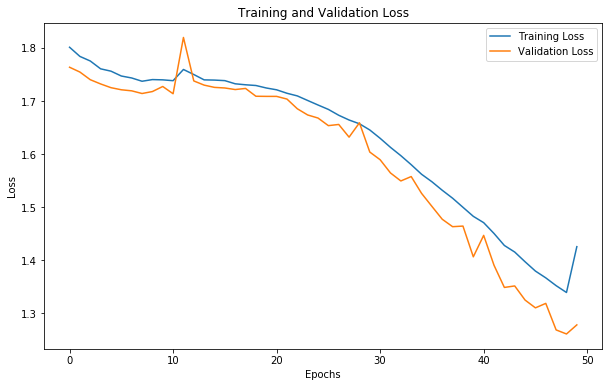

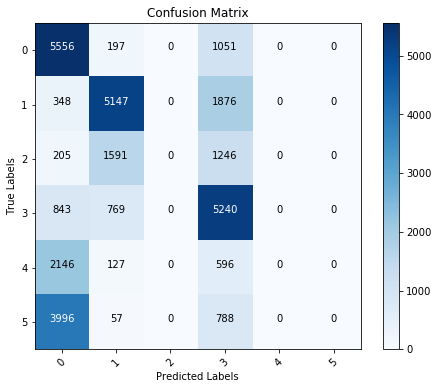

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.82      0.56      6804
           1       0.65      0.70      0.67      7371
           2       0.00      0.00      0.00      3042
           3       0.49      0.76      0.59      6852
           4       0.00      0.00      0.00      2869
           5       0.00      0.00      0.00      4841

    accuracy                           0.50     31779
   macro avg       0.26      0.38      0.30     31779
weighted avg       0.35      0.50      0.40     31779



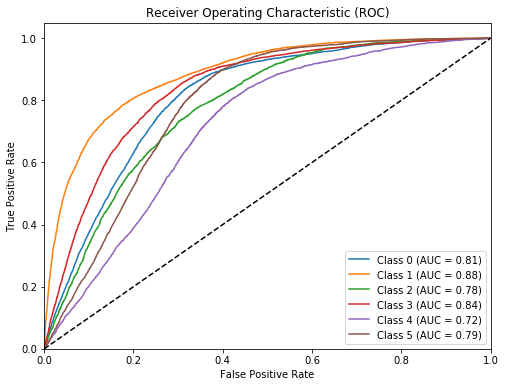

In [44]:

# Assuming you have already trained your 'final_model' and have test data 'X_tst_input_ids' and 'X_tst_attention_mask'
y_pred = final_model.predict([X_tst_input_ids, X_tst_attention_mask])

# Visualize Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Calculate confusion matrix
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['0', '1', '2', '3', '4', '5']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display confusion matrix values on the plot
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i][j]), horizontalalignment='center', color='white' if confusion[i][j] > confusion.max() / 2 else 'black')

plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [35]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Input text
input_text = "i am sad i am not on schedule for thesis"

# Tokenize and encode the input text
input_ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, padding=True, return_tensors='tf')

# Load the model using the directory name where it was saved
loaded_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
# Make predictions
predictions = loaded_model(input_ids)

# The predictions are in logit form; you can convert them to probabilities using a softmax
predicted_probabilities = tf.nn.softmax(predictions.logits, axis=-1)

# If you have labels for your classes, you can get the class with the highest probability
predicted_class = tf.argmax(predicted_probabilities, axis=-1)

# Print the predicted class and probabilities
print(f"Predicted Class: {predicted_class}")
print("Predicted Probabilities:", predicted_probabilities.numpy())


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Predicted Class: [1]
Predicted Probabilities: [[0.48899972 0.5110003 ]]


In [ ]:
# 1 means saddness hence it has classified correctly yet the probability is very low on unseen data